# **Master of Applied Artificial Intelligence**
## **Course: Advanced Machine Learning Methods**
### Tecnológico de Monterrey
### Prof José Antonio Cantoral Ceballos, Ph.D.

# TC 5033
## Word Embeddings

## **Activity 3b**
### **Text Classification using RNNs and AG_NEWS dataset in PyTorch**

## Group 2

### Juan Alfonso Vásquez Chapoi           A00820656

### Joel Orlando Hernández Ramos        A00759664

### Gerardo Aaron Castañeda Jaramillo A01137646

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confusion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In case the modules are not installed, we install the following in conda:

In [ ]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

We start importing the necessary libraries and modules for this activity, this includes numpy, torch, torchvision, scikitplot, torchtext. As well as some additional modules which allow us to work with datasets of PyTorch and apply transformation to them.

We make sure we have the following packages

In [ ]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

import time
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Prepare code to use CUDA if available, otherwise keep using CPU

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

For the classes in the dataset:

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

We import the train_dataset and test_dataset from the AG_NEWS() object, included in the torchtext.datasets module Then we apply the to_map_style_dataset function (object) which allows us to unpack the iterator which holds the train and test data, allowing us to access all the data at once through indices.

In [ ]:
train_dataset, test_dataset = AG_NEWS()                                                               #load to variables
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset) #convert to map-style

Lets see the first element in the train_dataset

In [ ]:
train_dataset[0]

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

We see that the shape of the data is a tuple of form (label, text)

We define a tokeniser object with the get_tokenizer function from the torchtext.data.utils module with the argument "basic_english" so that we apply that specific set of rules over the comments in the AG_News files to reduce the amount of possible tokens in the vocabulary.

We then define an interator named yield_tokens that makes use of the tokeniser object and we make sure only to enter the text from the comments (and not the labels)

In [ ]:
# Get the tokenizer
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:             # obtain the text from the data
        yield tokeniser(text)        # tokenize it

We then proceed to create our vocabulary using the build_vocab_from_iterator function from the torchtext.vocab module. we make use to use the specials flag for weird tokens to be set to <𝑢𝑛𝑘> from unknown.

The vocabulary is a mapping of token strings to unique integers. in the second line of code, by setting the default index to the index of  <𝑢𝑛𝑘>, we ensure that when we look up a token that is not in the vocabulary, we get the index of  <𝑢𝑛𝑘> instead of an error. This is crucial for handling out-of-vocabulary words gracefully when processing text data.

In [ ]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

We test our tokens and vocabulary, it is important to know that we will use both since the tokeniser is used to "tokenize" new data, while the vocab is used to get the indices of the matching tokens, in case a new token (not in vocab) is looked for, the 0 index is returned.

In [ ]:
tokens = tokeniser('Welcome to TE3007')  # tokenize the sentence
print(tokens, vocab(tokens))             # print the tokens, and their indexes

['welcome', 'to', 'te3007'] [3314, 4, 0]


We create two constants specifing that 90% of the train data is going to be used for training and the remaining 10% is used as validation data

In [ ]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

We make use of the random_split function imported from the torch.utils.data.dataset module

In [ ]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

We check the number of samples in each dataset (train, val and test)

In [ ]:
print('Train:', len(train_dataset), 'Validation:', len(val_dataset), 'Test:', len(test_dataset))

Train: 108000 Validation: 12000 Test: 7600


The following function is a complex one, we will create a special function that works with each batch of data and then process it so that we get the first two lists, one for labels and another for tokens. This is done for each sentence, so at the end, each element in both lists is going to be related to a specific review. To ensure all reviews are from the same dimension (while entering the data through the neural network) we make sure that the number of elements always matches a specific max_tokens variable. In case a review has fewer tokens than the max, 0s are padding to the end of the review and in case the review has more than the max_tokens value, the number of tokens is truncated up to this max_tokens number.

Afterward, we return both tensors, one for the " 𝑛
 " number of reviews, each with an " 𝑚
 " amount of max_tokens; and another tensor with the labels, ensuring the labels go from the range between 1-4 to the range between 0-3.

We need a function to process the data from the batches of the datasets. Similar to a pipeline. This function will be passed to the DataLoader.

In [ ]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    """
    Return batch information in the desired output.
    Either padd or limit X size to max_tokens size

    Args:
    - batch: the batch of data with Xs and ys information.

    Returns:
    - torch.tensor: Tensor with X data of dtype int32
    - torch.tensor: Tensor with y data of dtype int32 (substracting 1 to each number)
    """
    # Get label and text
    y, x = list(zip(*batch))                                        # batch has form (label, tokens), when unpacking and then ziping two lists are returned
                                                                    # each with the element-wise corresponding value for labels and tokens
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]                      # A vocabulary is made for all tokens in text, for all texts in batch
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x] # if tokens < max_tokens: tokens + ([0]*(max_tokens - len(tokens))
                                                                                                # else: tokens[:max_tokens] for token in indexes(from vocab)
                                                                                                # for the corresponding review being selected
    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1           # tensors are returned with tokens and labels (range 0-3)

We define our maximum number of tokens as 50, while our batch size as 32.

In [ ]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 32

The DataLoader objects are created considering batch_size, the collate function and a shuffle flag

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

For this part, we will consider the embedding_size variable, number of neurons per layer, number of layers, and number of output classes.

Before going forward we would like to explain the concept of "Embeddings" in this case. In Activity 3a we worked with a file already with words and embeddings, these embeddings were calculated via a neural network trained on a large corpus of text from Wikipedia; in this case, we are not going to use the embeddings from that training data, we are going to get them with this specific training data.

This is done via the neural network and the amount of neurons present in the embeddings layer. Through the training process this layer with weights of dimension (𝑏𝑎𝑡𝑐ℎ𝑠𝑖𝑧𝑒
, 𝑒𝑚𝑏𝑒𝑑𝑑𝑖𝑛𝑔𝑠′𝑐𝑜𝑚𝑝𝑜𝑛𝑒𝑛𝑡𝑠
) the weights are going to be calculated and updated via the backpropagation algorithm; since the loss function is going to be calculated against a certain number of labels (4) the weights are going to be updated that way and are going to innerly learn how to update themselves to best approximate each sentence in the minibatch to the right label. In this case, the embeddings are going to take the integers from each example in the batch (which are going to be limited by max_tokens) and then the layer is going to learn how to update its weights in a way that the tokens present in the 50 tokens yield to the right category. In this case, the network is going to use the embeddings as a bridge to learn how some words are related more deeply to a certain category than others.

It is important to notice here that the size of the vocabulary is n number of words plus a 0 index reserved for unknown words; however, in each iteration the network will receive a constant number of mini_batch size samples each with a max_vocab number of tokens.

### RNN Approach

In [ ]:
EMBEDDING_SIZE = 50
NEURONS_HIDDEN = int(EMBEDDING_SIZE*2)
LAYERS = 2
NUM_CLASSES = 4

Next, we define our RNN model:

Our first approach was to build a normal RNN and see how it performs at this classification problem.

In [ ]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes, vocab):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        # complete this code/
        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()
        self.rnn = nn.RNN(input_size=embed_size,
                  hidden_size=hidden,
                  num_layers=layers,
                  nonlinearity="tanh",
                  bias=True,
                  batch_first=True)

        # complete output classifier layer using linear layer
        self.fc = nn.Linear(in_features=hidden, out_features=num_classes, bias=True)

    def forward(self, x):
        # implement forward pass. This function will be called when executing the model
        x = self.embedding_layer(x)             # Embedding layer
        x, _ = self.rnn(x)                      # RNN layer
        x = x[:, -1, :]                         # Get the last hidden state by selecting
                                                # "for all items in the batch (:), select the last time step (-1),
                                                # and all features (:)".
        x = self.fc(x)                          # Output classifier layer

        return x

Lets analyze our class

We check the model definition and we can see that we have the number of neurons well defined:

The number of embedding dimension should match the input_size dimension in the RNN and then the output_size in the RNN should match the in_features parameter in the fully connected final layer

In [ ]:
RNN1 = RNN_Model_1(embed_size=EMBEDDING_SIZE, hidden=NEURONS_HIDDEN, layers = LAYERS, num_classes=NUM_CLASSES, vocab=vocab)
RNN1

RNN_Model_1(
  (embedding_layer): Embedding(95811, 50)
  (rnn): RNN(50, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=4, bias=True)
)

Lets analyze our forward pass, for this we will need to get a sample from the data loader

In [ ]:
counter = 0
for element in train_loader:
    if counter < 1:
        counter += 1
        sample_0 = element
        print(element)
        print(len(element))
    else:
        break

(tensor([[  266,  1269,   279,  ...,     0,     0,     0],
        [ 3322,  3475,  4692,  ...,     0,     0,     0],
        [20222,   402,  7437,  ...,     0,     0,     0],
        ...,
        [   23,   618,   624,  ...,     0,     0,     0],
        [ 3055,  5844,  1679,  ...,     0,     0,     0],
        [ 7952,  1339,    24,  ...,     0,     0,     0]], dtype=torch.int32), tensor([0, 0, 1, 3, 3, 3, 0, 0, 0, 2, 1, 1, 3, 0, 0, 0, 3, 1, 0, 3, 2, 3, 2, 1,
        2, 3, 3, 3, 1, 0, 3, 0], dtype=torch.int32))
2


In [ ]:
print(sample_0[0].size())      # We observe the size of tensor in position 0
print(sample_0[1].size())      # We observe the size of tensor in position 1

torch.Size([32, 50])
torch.Size([32])


We call our forward method, just for the Xs!

In [ ]:
RNN1_preview= RNN1.forward(sample_0[0])
RNN1_preview

tensor([[-0.3620,  0.0072,  0.0810, -0.1471],
        [-0.3619,  0.0073,  0.0811, -0.1471],
        [-0.3619,  0.0072,  0.0811, -0.1472],
        [-0.3237, -0.1638, -0.2326,  0.0867],
        [-0.3619,  0.0073,  0.0811, -0.1471],
        [-0.3633,  0.0073,  0.0811, -0.1499],
        [-0.4612, -0.0369,  0.1736, -0.3374],
        [-0.1179,  0.2975, -0.0570,  0.0229],
        [ 0.1605,  0.1494, -0.0841, -0.0136],
        [-0.1259,  0.0175, -0.0183,  0.0716],
        [-0.2002,  0.2623, -0.2939, -0.0259],
        [-0.3619,  0.0073,  0.0809, -0.1475],
        [-0.2260,  0.1587,  0.0198, -0.0824],
        [-0.3709,  0.0017,  0.0663, -0.1531],
        [-0.3615,  0.0100,  0.0802, -0.1479],
        [-0.3619,  0.0073,  0.0811, -0.1471],
        [-0.3398, -0.0039, -0.2424, -0.1388],
        [-0.3628,  0.0078,  0.0802, -0.1473],
        [-0.3620,  0.0073,  0.0809, -0.1473],
        [-0.3620,  0.0105,  0.0795, -0.1516],
        [-0.3619,  0.0073,  0.0811, -0.1473],
        [-0.3436,  0.0020,  0.0575

In [ ]:
RNN1_preview.size()

torch.Size([32, 4])

In order to get the label that has the greater probability we could get the softmax probability function and then calculate the average loss. We can do this via the cross_entropy function in the functional module, before this we need targets to be in dtype of torch.long

In [ ]:
target_0 = sample_0[1].to(torch.long)

In [ ]:
F.cross_entropy(RNN1_preview, target_0, size_average=None)

tensor(1.4322, grad_fn=<NllLossBackward0>)

Now that we have seen how is the data entered into the model and how is the data process by it we will make the accuracy and training functions

#### Accuracy Funtion

In [ ]:
def accuracy(model, loader):
    """
    Compute the accuracy of a model using data from a loader.

    Args:
    - model (torch.nn.Module): The PyTorch model.
    - loader (torch.utils.data.DataLoader): The data loader.

    Returns:
    - float: The cost of the model on the provided data.
    - float: The accuracy of the model on the provided data.
    """
    correct = 0
    total_examples = 0
    cost = 0

    model.eval()                                             # We set the model to evaluate to avoid gradient computarions
    model = model.to(device=device)                          # We make sure we load the model in GPU if available
    with torch.no_grad():                                    # We desable the gradient calculation process since in this point we are not traning the model
        for xi,yi in loader:                                 # We get in two variables all the MINIBATCH_SIZE x and y values
            xi = xi.to(device=device, dtype = torch.int32)   # We make sure the dtype in the Xs are of type tensor.int 32 (since emb. Layer needs int data)
            yi = yi.to(device=device, dtype = torch.long)    # We make sure the dtype in the ys are of type tensor.long
            y_hat = model(xi)                                # We get the samples in the model to get the results
            cost += (F.cross_entropy(y_hat, yi)).item()      # We get Cost Value from the batch

            _, pred = y_hat.max(dim=1)           # We get the index with the maximum score
            correct += (pred == yi).sum()        # We get the correct number of predictions by adding where the indices make match
            total_examples += pred.size(0)       # Get Batch_size
        total_examples = float(total_examples)   # Convert final total_examples to float (Redundant, Failure preventing)

    return float(cost)/total_examples, float(correct)/total_examples

#### Train Function

In [ ]:
def train(model, optimiser, epochs=100):
    """
    Train a PyTorch model.

    Parameters:
    - model: the neural network model
    - optimizer: optimizer for training
    - epochs: number of epochs to train for

    Returns:
    - Print a statement showing each epoch's average train and val cost and accuracy
    - train_acc_list: list of accuracy values in training for each epoch
    - train_cost_list: list of cost values in training for each epoch
    - val_acc_list: list of accuracy values in validation for each epoch
    - val_cost_list: list of cost values in validation for each epoch
    """
    print(f'lr: {optimiser.param_groups[0]["lr"]:.6f}')         # Print the learning rate that the optimiser uses
    model = model.to(device=device)                             # Before anything we make sure we are loading to CUDA if available
    train_acc_list = []; val_acc_list = []                      # We define two empty lists to store accuracy values
    train_cost_list = []; val_cost_list = []                    # We define two empty lists to store cost values
    for epoch in range(epochs):                                 # A loop is made for epochs number of iterations
        train_correct_num  = 0.
        train_total = 0.
        train_cost = 0.                                         # Initialize the training cost as floating 0 at each EPOCH
        val_cost = 0.                                           # Initialize the validation cost as floating 0 at each EPOCH
        train_cost_acum = 0
        for  xi, yi in train_loader:                            # The train_loader is called within a loop, getting the X,y pairs
            model.train()                                       # Model is set to train, since gradient computation is needed
            xi = xi.to(device=device, dtype=torch.int32)        # We make sure the dtype in the Xs are of type tensor.int32 (since emb. Layer needs int data)
            yi = yi.to(device=device, dtype=torch.long)         # We make sure the dtype in the ys are of type tensor.long
            y_hat = model(xi)                                   # We generate the outputs scores for our model batch Xs

            # funcion cost
            cost = F.cross_entropy(input= y_hat, target=yi.squeeze())  # Cost function is defined as CXEntropy, where scores and targets are given
            optimiser.zero_grad()                                      # We set the previous gradients to 0 to avoid gradient accumulation during training
            cost.backward()                                            # We execute the running pass, calculating the gradients of the L-function w/respect parameters
            optimiser.step()                                           # We update parameters following a given optimizer

            # We calculate train accuracy and cost here, instead of the accuracy() function, to get a better training time
            train_correct_num += (torch.argmax(y_hat, dim=1) == yi.squeeze()).sum() # For each BATCH_SIZE samples we get the number of correct predictions, accumulating
            train_total += y_hat.size(0)                                            # For each BATCH_SIZE samples we get the number of total predictions, accumulating
            train_cost_acum += cost.item()                                          # From the object returning from CXEntropy the total cost is accumulated

        train_acc = float(train_correct_num)/train_total               # Get Epoch's Average Accuracy
        train_cost = train_cost_acum/train_total                       # Get Epoch's Average Training Cost

        val_cost, val_acc = accuracy(model, val_loader)         # accuracy function is called (setting model to eval), getting validation cost and accuracy
                                                                # since accuracy receives a data loader and iterates over it, it will get an "Epoch's val average"

        train_acc_list.append(train_acc); val_acc_list.append(val_acc)          # Store accuracy values in their lists
        train_cost_list.append(train_cost); val_cost_list.append(val_cost)      # Store costs values in their lists

        print(f'Epoch:{epoch+1}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
              f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}')
    return train_acc_list, train_cost_list, val_acc_list, val_cost_list

We define the number of epochs and learning rate that we will use in our model, we also create an instance of the class RNN_Model_1.
We also define our optimiser to be Adam

In [ ]:
epochs = 20
lr = 2e-4                           #4e-4 for 50 embeding dim
# instantiate model
rnn_model = RNN_Model_1(embed_size=EMBEDDING_SIZE, hidden=NEURONS_HIDDEN, layers=LAYERS, num_classes=NUM_CLASSES, vocab=vocab)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

We use the usefull time library to get the amount of time needed for our training for the number of epochs defined.
We also assing the results of the training process to the train_acc, train_cost, val_acc and val_cost variables

In [ ]:
import time
start = time.time()    # We store the time to calculate the total training time of the model

# The 4 outputs of the train() function are the lists storing their respective values in each epoch
train_acc, train_cost, val_acc, val_cost = train(rnn_model, optimiser, epochs)

end = time.time()     # Now, we store the time when it finishes training
print(f'Total training time: {(end - start)/60:.4f} mins') # And we print it

lr: 0.000200
Epoch:1, train cost: 0.041437, val cost: 0.036788, train acc: 0.3430, val acc: 0.458583
Epoch:2, train cost: 0.032517, val cost: 0.028500, train acc: 0.5234, val acc: 0.588833
Epoch:3, train cost: 0.027303, val cost: 0.024323, train acc: 0.6040, val acc: 0.650000
Epoch:4, train cost: 0.023842, val cost: 0.023657, train acc: 0.6549, val acc: 0.671833
Epoch:5, train cost: 0.022410, val cost: 0.022532, train acc: 0.6763, val acc: 0.688667
Epoch:6, train cost: 0.023919, val cost: 0.022648, train acc: 0.6677, val acc: 0.686083
Epoch:7, train cost: 0.020715, val cost: 0.021857, train acc: 0.7093, val acc: 0.704083
Epoch:8, train cost: 0.019647, val cost: 0.018883, train acc: 0.7428, val acc: 0.779583
Epoch:9, train cost: 0.019225, val cost: 0.020798, train acc: 0.7537, val acc: 0.697917
Epoch:10, train cost: 0.022518, val cost: 0.040321, train acc: 0.6779, val acc: 0.400833
Epoch:11, train cost: 0.025598, val cost: 0.022868, train acc: 0.6337, val acc: 0.706917
Epoch:12, train c

We test the overall accurary in our test data using our trained model

In [ ]:
print(f'The overall accuracy of the trained model using the test data is: {(accuracy(rnn_model, test_loader)[1]) * 100:.2f} %')

The overall accuracy of the trained model using the test data is: 86.53 %


We create a function that allows us to plot the training and validation accuracy and costs along the epochs

In [ ]:
import matplotlib.pyplot as plt
def plot_train_val(TL, VL, graph):
    """
    Plot training vs. validation values for accuracy and cost.

    Parameters:
    - TL: a list with the training values
    - VL: a list with the validation values
    - graph: a boolean where True: accuracy and False: cost
    """
    plt.figure(figsize=(7,4))             # We define the size of the plot
    epochs_range = range(1,len(TL)+1)     # We define size of X in the plot, according to the number of epochs
    if graph:                             # If 'True' the we are working for accuracy values
        graph_type = 'Accuracy'
    else:                                 # If 'False' the we are working for cost values
        graph_type = 'Cost'
    plt.plot(epochs_range, TL, 'g', label='Training ' + graph_type)    # Plot the training values
    plt.plot(epochs_range, VL, 'b', label='Validation ' + graph_type)  # Plot the validation values
    plt.title('Training and Validation ' + graph_type)                 # Define the title of the graph
    plt.xlabel('Epochs')                                               # Define the label for X
    plt.ylabel(graph_type)                                             # Define the label for Y
    plt.legend()                                                       # Display the legend in the plot
    plt.show()                                                         # Show the plot

We plot the training and validation accuracy

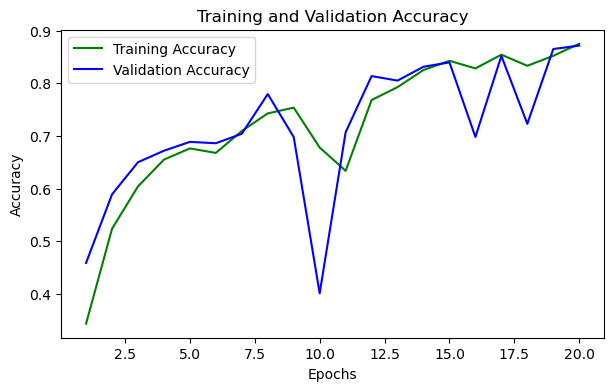

In [ ]:
plot_train_val(train_acc, val_acc, True)

We plot the train and validation cost

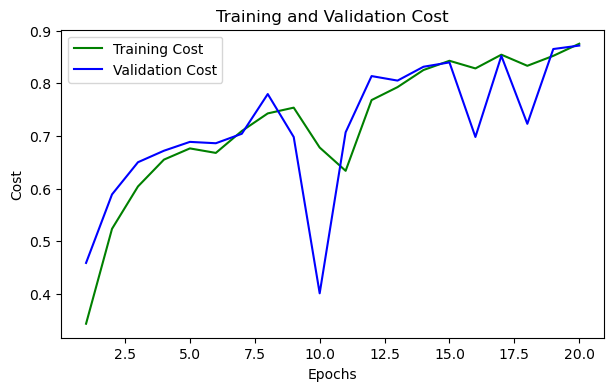

In [ ]:
plot_train_val(train_acc, val_acc, False)

From the graphs we can see that the model would start to overfit for longer epochs; however up to 20 epochs we do not see a very strong impact of overfitting

### LSTM Approach

Due to the presence of extremely lengthy sequences, we will employ an LSTM layer to consider extended-range influences. Our approach to sentiment analysis involves the construction of an RNN model. This model begins with an embedding layer, which generates word embeddings with a dimensionality of 50. Subsequently, we introduce a recurrent LSTM layer. To complete the model, we include a hidden fully connected layer and an additional fully connected layer as the output layer. The output layer employs a logistic sigmoid activation function to provide a predictive probability value for class membership across four classes.

In [ ]:
EMBEDDING_SIZE = 50
NEURONS = 200
NEURONS2 = 100
LAYERS = 2
NUM_CLASSES = 4

In [ ]:
class RNN_Model_2(nn.Module):
    def __init__(self, embed_size, hidden, hidden2, layers, num_classes):
        """
        - self: the instance of the class
        - embed_size: embeddings' dimensionality
        - hidden: output of the LSTM
        - hidden2: output the hidden fully connected layer
        """
        super().__init__()                                                                  # init classes
        self.embedding = nn.Embedding(len(vocab), embedding_dim=embed_size, padding_idx=0)  # define embedding layer
        self.rnn = nn.LSTM(embed_size, hidden, batch_first=True)                            # define LSTM
        self.fc1 = nn.Linear(hidden, hidden2)                                               # define hidden fully connected layer
        self.relu = nn.ReLU()                                                               # apply ReLU
        self.fc2 = nn.Linear(hidden2, num_classes)                                          # define output fully connected layer
        self.sigmoid = nn.Sigmoid()                                                         # apply sigmoid


    def forward(self, x, lengths):
        """
        Function to be used when calling the class

        Parameters:
        - self: the instance of the class
        - x: input tensor of tokenized texts
        - lengths: tensor with the length of all texts
        Returns:
        - The output of the RNN
        """
        x = self.embedding(x)                                                          # Embedding layer
        x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu().numpy(),                # function is used to pack the sequences
                                              enforce_sorted=False, batch_first=True)  # and their lengths into a special format
                                                                                       # that allows for efficient processing
        x, (hidden, cell) = self.rnn(x)                                                # RNN layer
        x = hidden[-1, :, :]                                                           # hidden state of the last time step in the batch
        x = self.fc1(x)                                                                # linear transformation on the input
        x = self.relu(x)                                                               # apply ReLU
        x = self.fc2(x)                                                                # fully connected layer
        x = self.sigmoid(x)                                                            # apply sigmoid
        return x

Let's analyze our class

We check the model definition and we can see that we have the number of neurons well defined:

The number of embedding dimensions should match the input_size dimension in the RNN and then the output_size in the RNN should match the in_features parameter in the hidden fully connected layer. While the output_size of the previous layer matches the in_features of the final fully connected layer. Which ends with 4 out_features, out 4 classes.

In [ ]:
lstm_model = RNN_Model_2(embed_size=EMBEDDING_SIZE, hidden=NEURONS, hidden2 = NEURONS2, layers = LAYERS, num_classes=NUM_CLASSES)
lstm_model

RNN_Model_2(
  (embedding): Embedding(95811, 50, padding_idx=0)
  (rnn): LSTM(50, 200, batch_first=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (sigmoid): Sigmoid()
)

Lets analyze our forward pass, for this we will need to get a sample from the data loader

In [ ]:
counter = 0
for element in train_loader:
    if counter < 1:
        counter += 1
        sample_0 = element
        print(element)
        print(len(element))
    else:
        break

(tensor([[  554,  1948,  3091,  ...,     0,     0,     0],
        [  128, 23858,   111,  ...,     0,     0,     0],
        [  816,  4910,  4868,  ...,   435,  1235,    12],
        ...,
        [    9,     1,  2883,  ...,     0,     0,     0],
        [ 4701,    59,     6,  ...,     0,     0,     0],
        [  168,   328,  1286,  ...,     0,     0,     0]], dtype=torch.int32), tensor([1, 2, 0, 2, 1, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 3, 1, 3, 0, 3, 2, 0, 3, 3,
        1, 0, 1, 2, 2, 2, 1, 0], dtype=torch.int32))
2


In [ ]:
print(sample_0[0].size())      # We observe the size of tensor in position 0
print(sample_0[1].size())      # We observe the size of tensor in position 1

torch.Size([32, 50])
torch.Size([32])


Now we can define the accuracy and training functions, as in previous activities. With the difference that here we define a tensor with the lengths of the 'xi' tensors. Which will be used in the forward pass of the model, with the pack_padded_sequence() function. It could have been set up as a return value of the collate_batch() function, but as instructed in the activity, we didn't modify that function.

#### Accuracy Funtion (Adapted For LSTM)

In [ ]:
def accuracy(model, loader):
    """
    Compute the accuracy of a model using data from a loader.

    Args:
    - model (torch.nn.Module): The PyTorch model.
    - loader (torch.utils.data.DataLoader): The data loader.

    Returns:
    - float: The cost of the model on the provided data.
    - float: The accuracy of the model on the provided data.
    """
    num_correct = 0
    num_total = 0
    cost = 0.
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():                                           # We disable the gradient calculation process since in this point we are not traning the model
        for (xi, yi) in loader:                                     # We get in two variables all the MINIBATCH_SIZE x and y values
            xi = xi.to(device=device, dtype = torch.int32)          # We make sure the dtype in the Xs are of type tensor.float32
            yi = yi.to(device=device, dtype = torch.long)           # We make sure the dtype in the ys are of type tensor.long
            lengths = []                                            # Empty list to fill with the lengths of the xis
            for temp in xi:                                         # Iterate through every element in xi
                lengths.append(len(temp))                           # Append it to the list
            lengths = torch.tensor(lengths, dtype=torch.int32)      # convert to tensor with dtype int32
            scores = model(xi, lengths)                             # We get the samples in the model to get the results (scores)
            cost += (F.cross_entropy(scores, yi)).item()            # We calculate the cost and accumulate it for all batches
            _, pred = scores.max(dim=1)                             # We apply the .max() method to the scores tensor along 1 dimension (mini_batch, classes)
                                                                    # along dim 1 allows to get the maximum score for each row (each mini_batch)
                                                                    # max() returns the value and its position (similar to torch.argmax), we save just the index (class)
            num_correct += (pred == yi).sum()                       # pred shape (mb_size), yi shape (mb_size, 1), Get True and Falses where indices make match
            num_total += pred.size(0)                               # Number of predictions, equal to batch_size
        return float(cost)/num_total, float(num_correct)/num_total  # At the end of all the batches, the overall accuracy for the epoch is computed

#### Train Funtion (Adapted For LSTM)

In [ ]:
def train(model, optimiser, epochs=100):
    """
    Train a PyTorch model.

    Parameters:
    - model: the neural network model
    - optimizer: optimizer for training
    - epochs: number of epochs to train for

    Returns:
    - Print a statement showing each epoch's average train and val cost and accuracy
    - train_acc_list: list of accuracy values in training for each epoch
    - train_cost_list: list of cost values in training for each epoch
    - val_acc_list: list of accuracy values in validation for each epoch
    - val_cost_list: list of cost values in validation for each epoch
    """
    print(f'lr: {optimiser.param_groups[0]["lr"]:.6f}')         # Print the learning rate that the optimiser uses
    model = model.to(device=device)                             # Before anything we make sure we are loading to CUDA if available
    train_acc_list = []; val_acc_list = []                      # We define two empty lists to store accuracy values
    train_cost_list = []; val_cost_list = []                    # We define two empty lists to store cost values
    for epoch in range(epochs):                                 # A loop is made for epochs number of iterations
        train_correct_num  = 0.
        train_total = 0.
        train_cost = 0.                                         # Initialize the training cost as floating 0 at each EPOCH
        val_cost = 0.                                           # Initialize the validation cost as floating 0 at each EPOCH
        train_cost_acum = 0
        for  xi, yi in train_loader:                            # The train_loader is called within a loop, getting the X,y pairs
            model.train()                                       # Model is set to train, since gradient computation is needed
            xi = xi.to(device=device, dtype=torch.int32)        # We make sure the dtype in the Xs are of type tensor.float32
            yi = yi.to(device=device, dtype=torch.long)         # We make sure the dtype in the ys are of type tensor.long
            lengths = []                                            # Empty list to fill with the lengths of the xis
            for temp in xi:                                         # Iterate through every element in xi
                lengths.append(len(temp))                           # Append it to the list
            lengths = torch.tensor(lengths, dtype=torch.int32)      # convert to tensor with dtype int32
            y_hat = model(xi, lengths)                              # We generate the outputs scores for our model batch Xs

            # funcion cost
            cost = F.cross_entropy(input= y_hat, target=yi.squeeze())  # Cost function is defined as CXEntropy, where scores and targets are given
            optimiser.zero_grad()                                      # We set the previous gradients to 0 to avoid gradient accumulation during training
            cost.backward()                                            # We execute the running pass, calculating the gradients of the L-function w/respect parameters
            optimiser.step()                                           # We update parameters following a given optimizer

            # We calculate train accuracy and cost here, instead of the accuracy() function, to get a better training time
            train_correct_num += (torch.argmax(y_hat, dim=1) == yi.squeeze()).sum() # For each BATCH_SIZE samples we get the number of correct predictions, accumulating
            train_total += y_hat.size(0)                                            # For each BATCH_SIZE samples we get the number of total predictions, accumulating
            train_cost_acum += cost.item()                                          # From the object returning from CXEntropy the total cost is accumulated

        train_acc = float(train_correct_num)/train_total               # Get Epoch's Average Accuracy
        train_cost = train_cost_acum/train_total                       # Get Epoch's Average Training Cost

        val_cost, val_acc = accuracy(model, val_loader)         # accuracy function is called (setting model to eval), getting validation cost and accuracy
                                                                # since accuracy receives a data loader and iterates over it, it will get an "Epoch's val average"

        train_acc_list.append(train_acc); val_acc_list.append(val_acc)          # Store accuracy values in their lists
        train_cost_list.append(train_cost); val_cost_list.append(val_cost)      # Store costs values in their lists

        print(f'Epoch:{epoch+1}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
              f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}')
    return train_acc_list, train_cost_list, val_acc_list, val_cost_list

We define the number of epochs and learning rate that we will use in our model, the instance of the class RNN_Model_2, and we define our optimiser to be Adam:

In [ ]:
epochs = 10
lr = 0.001                       #4e-3 for 50 embeding dim
loss_fn = nn.CrossEntropyLoss()  #define loss function
lstm_model = RNN_Model_2(EMBEDDING_SIZE, NEURONS, NEURONS2, LAYERS, NUM_CLASSES)  # instantiate model
optimiser = torch.optim.Adam(lstm_model.parameters(), lr=lr)   #define optimizer

Let's observe the model:

We use the useful time library to get the amount of time needed for our training for the number of epochs defined. We also assing the results of the training process to the train_acc, train_cost, val_acc and val_cost variables

In [ ]:
start = time.time()    # We store the time to calculate the total training time of the model

train_acc, train_cost, val_acc, val_cost = train(lstm_model, optimiser=optimiser, epochs=epochs)

end = time.time()     # Now, we store the time when it finishes training
print(f'Total training time: {(end - start)/60:.4f} mins') # And we print it

lr: 0.001000
Epoch:1, train cost: 0.041283, val cost: 0.042908, train acc: 0.3394, val acc: 0.344750
Epoch:2, train cost: 0.036677, val cost: 0.035741, train acc: 0.4488, val acc: 0.465167
Epoch:3, train cost: 0.035764, val cost: 0.034976, train acc: 0.4608, val acc: 0.479417
Epoch:4, train cost: 0.032144, val cost: 0.029491, train acc: 0.5826, val acc: 0.672333
Epoch:5, train cost: 0.027951, val cost: 0.027054, train acc: 0.7899, val acc: 0.868833
Epoch:6, train cost: 0.026309, val cost: 0.026570, train acc: 0.8934, val acc: 0.883917
Epoch:7, train cost: 0.025787, val cost: 0.026483, train acc: 0.9130, val acc: 0.887750
Epoch:8, train cost: 0.025472, val cost: 0.026221, train acc: 0.9239, val acc: 0.896167
Epoch:9, train cost: 0.025253, val cost: 0.026262, train acc: 0.9322, val acc: 0.896667
Epoch:10, train cost: 0.025094, val cost: 0.026198, train acc: 0.9377, val acc: 0.900083
Total training time: 4.7870 mins


We test the overall accurary in our test data using our trained model

In [ ]:
print(f'{accuracy(lstm_model, test_loader)[1]:.2f}')

0.90


We plot the training and validation accuracy

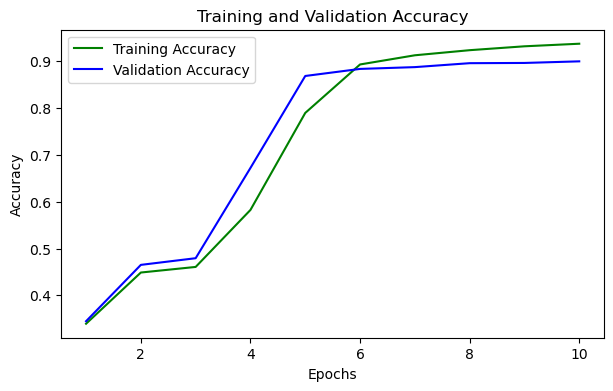

In [ ]:
plot_train_val(train_acc, val_acc, True)

We plot the train and validation cost

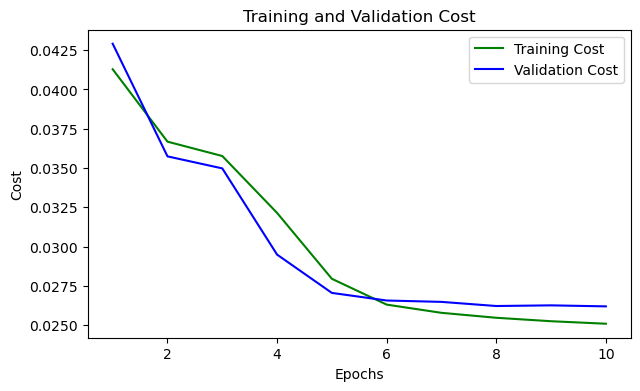

In [ ]:
plot_train_val(train_cost, val_cost, False)

From the graphs we can see that the model would start to overfit for longer epochs; however up to 10 epochs we do not see a very strong impact of overfitting

### Text Sampling

We include the following function in which we prepare our model to be set in evaluation mode and receive the data from the loader. In this case, we create two general lists y_hats and yis which are intended to hold all the y_hat (predictions) and all the yi (real labels). We create a loop to unpack the iterator and then we add all the elements of y_hat and yi from that batch with the extend method to avoid having the batch dimension in the y_hats and yis. This will help us with further functions.

In [ ]:
def sample_text(model, loader, model_type):
    """
    Unpack values for predictions and original labels in a certain loader
    using a certain trained model.

    Parameters:
    - model: a model expecting as inputs a tensor of type int32
    - loader: a dataloader able to produce mini_batches

    Returns:
    - y_hats: a list with all predictions from all the samples in the loader
    - yis a list with all real labels from all the samples in the loader
    """
    y_hats = []
    yis = []

    model.eval()                                             # We set the model to evaluate to avoid gradient computarions
    model = model.to(device=device)                          # We make sure we load the model in GPU if available
    with torch.no_grad():                                    # We desable the gradient calculation process since in this point we are not traning the model
        for xi,yi in loader:                                 # We get in two variables all the MINIBATCH_SIZE x and y values
            xi = xi.to(device=device, dtype = torch.int32)   # We make sure the dtype in the Xs are of type tensor.int 32 (since emb. Layer needs int data)
            yi = yi.to(device=device, dtype = torch.long)    # We make sure the dtype in the ys are of type tensor.long
            lengths = []                                            # Empty list to fill with the lengths of the xis
            for temp in xi:                                         # Iterate through every element in xi
                lengths.append(len(temp))                           # Append it to the list
            lengths = torch.tensor(lengths, dtype=torch.int32)      # convert to tensor with dtype int32
            if model_type == 'lstm':             # We get the samples in the model to get the results
                y_hat = model(xi, lengths)       # if it is lstm, then send the lengths
            else:
                y_hat = model(xi)                # if not, just the samples
            _, pred = y_hat.max(dim=1)           # We get the index with the maximum score
            y_hats.extend(pred)                  # we extend the predictions of the current batch in the y_hats list
            yis.extend(yi)                       # we extend the predictions of the current batch in the yis list, this allow to have all samples in loader
                                                 # in the same dimension.

    return y_hats, yis

We will use our previously defined function to get the predictions and results Then we will make a loop to get 20 random positions from both lists, compare the values and see how the model works for this examples

#### Using RNN Model

In [ ]:
y_hats, yis = sample_text(rnn_model, test_loader, 'rnn')                            # get predictions and real values for test_loader

correct = 0
for i in np.random.choice(len(yis), 20, replace=False):                      # iterate for 20 random indexes
    pred_eval = False
    if y_hats[i] == yis[i]:                                                  # if the prediction is correct...
        pred_eval = True                                                     # save it as true
        correct += 1                                                         # add 1 to the counter
    print(f"sample {i}\t has prediction value of {y_hats[i]} and a real label of {yis[i]} \t {pred_eval}")
print(f"Accuracy value is {correct/20*100:.2f} %")

sample 7570	 has prediction value of 2 and a real label of 2 	 True
sample 6993	 has prediction value of 1 and a real label of 1 	 True
sample 6221	 has prediction value of 1 and a real label of 1 	 True
sample 1107	 has prediction value of 2 and a real label of 2 	 True
sample 1137	 has prediction value of 2 and a real label of 2 	 True
sample 5040	 has prediction value of 1 and a real label of 1 	 True
sample 327	 has prediction value of 1 and a real label of 1 	 True
sample 4633	 has prediction value of 3 and a real label of 3 	 True
sample 1063	 has prediction value of 3 and a real label of 3 	 True
sample 5646	 has prediction value of 0 and a real label of 0 	 True
sample 6407	 has prediction value of 3 and a real label of 3 	 True
sample 2311	 has prediction value of 1 and a real label of 1 	 True
sample 2515	 has prediction value of 3 and a real label of 3 	 True
sample 3390	 has prediction value of 0 and a real label of 0 	 True
sample 6562	 has prediction value of 2 and a real

#### Using LSTM Model

In [ ]:
y_hats, yis = sample_text(lstm_model, test_loader, 'lstm')                            # get predictions and real values for test_loader

correct = 0
for i in np.random.choice(len(yis), 20, replace=False):                      # iterate for 20 random indexes
    pred_eval = False
    if y_hats[i] == yis[i]:                                                  # if the prediction is correct...
        pred_eval = True                                                     # save it as true
        correct += 1                                                         # add 1 to the counter
    print(f"sample {i}\t has prediction value of {y_hats[i]} and a real label of {yis[i]} \t {pred_eval}")
print(f"Accuracy value is {correct/20*100:.2f} %")

sample 6782	 has prediction value of 0 and a real label of 0 	 True
sample 1418	 has prediction value of 3 and a real label of 3 	 True
sample 6871	 has prediction value of 0 and a real label of 0 	 True
sample 6610	 has prediction value of 1 and a real label of 1 	 True
sample 6786	 has prediction value of 1 and a real label of 1 	 True
sample 2910	 has prediction value of 3 and a real label of 3 	 True
sample 7199	 has prediction value of 3 and a real label of 3 	 True
sample 258	 has prediction value of 3 and a real label of 3 	 True
sample 5485	 has prediction value of 0 and a real label of 0 	 True
sample 2906	 has prediction value of 0 and a real label of 0 	 True
sample 659	 has prediction value of 2 and a real label of 2 	 True
sample 554	 has prediction value of 1 and a real label of 1 	 True
sample 5508	 has prediction value of 2 and a real label of 2 	 True
sample 3736	 has prediction value of 1 and a real label of 1 	 True
sample 2653	 has prediction value of 1 and a real l

We will now create a function where any random text can be given and we will see the classification of the model

In [ ]:
def free_text(model, text, model_type):
    """
    Runs a string input into the model, previously preparing the input
    for be given into the model

    Parameters:
    - model: a model expecting as inputs a tensor of type int32
    - text: random string given by the programmer

    Returns:
    - Print statement giving the category the model predicts based on training
    """

    tkns = tokeniser(f"{text}")                              # We tokenize our input based on tokeniser defined
    x = vocab(tkns)                                          # We asing an integer for each token in tkns
    #print(x)
    x = [x + ([0]*(max_tokens - len(x))) if len(x) < max_tokens else x[:max_tokens]]    # The list of tokens x is padded with [0]s until 50 positions or
                                                                                        # truncated to 50 tokens to get the data into the neural network
    lengths = []                                            # Empty list to fill with the lengths of the xs
    for temp in x:                                          # Iterate through every element in x
        lengths.append(len(temp))                           # Append it to the list
    lengths = torch.tensor(lengths, dtype=torch.int32)      # convert to tensor with dtype int32

    # Convert list to tensor
    my_tensor = torch.tensor(x, dtype=torch.int32)           # We convert the list to a PyTorch Tensor
    my_tensor = my_tensor.to(device=device)                  # We make sure it is in CUDA if CUDA avaialble the list to a PyTorch Tensor



    model.eval()                                             # We set the model to evaluate to avoid gradient computarions
    model = model.to(device=device)                          # We make sure we load the model in GPU if available
    with torch.no_grad():                                    # We desable the gradient calculation process since in this point we are not traning the model
        if model_type == 'lstm':
            y_hat = model(my_tensor, lengths)
        else:
            y_hat = model(my_tensor)
        _, pred = y_hat.max(dim=1)           # We get the index with the maximum score

        print("Category", ["World", "Sports", "Business", "Sci/Tech"][pred[0].item()])

Running an example where we can see the Topic is clearly of Science Technology

In [ ]:
print("Result using RNN Model")
free_text(rnn_model, "Neural Networks are great for Narutal Language Processing Tasks\n", 'rnn')

print("Result using LSTM Model")
free_text(lstm_model, "Neural Networks are great for Narutal Language Processing Tasks\n", 'lstm')

Result using RNN Model
Category Sci/Tech
Result using LSTM Model
Category Sci/Tech


Running an example where we can see the Topic is clearly of Sports

In [ ]:
print("Result using RNN Model")
free_text(rnn_model, "Neural Networks are great for Narutal Language Processing Tasks\n", 'rnn')

print("Result using LSTM Model")
free_text(lstm_model, "Neural Networks are great for Narutal Language Processing Tasks\n", 'lstm')

Result using RNN Model
Category Sci/Tech
Result using LSTM Model
Category Sci/Tech


### Confusion Matrix

To observe the behavior of the predictions of the 4 classes, we can generate a confusion matrix. We'll use the confusion matrix module from sklearn.

#### RNN Model

<Axes: >

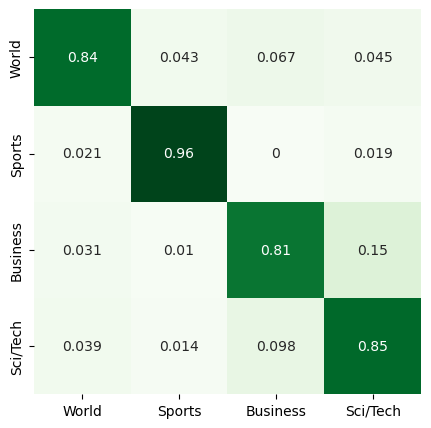

In [ ]:
y_pred = []; y_true = []                                          # lists to store predicted and real classes

for inputs, classes in test_loader:                              # iterate over test data
        inputs = inputs.to(device=device, dtype=torch.int32)     # We make sure the dtype in the Xs are of type tensor.float32
        classes = classes.to(device=device, dtype=torch.long)    # We make sure the dtype in the ys are of type tensor.long
        lengths = []                                            # Empty list to fill with the lengths of the xs
        for temp in inputs:                                          # Iterate through every element in x
            lengths.append(len(temp))                           # Append it to the list
        lengths = torch.tensor(lengths, dtype=torch.int32)      # convert to tensor with dtype int32
        output = rnn_model(inputs)                               # We feed Network with the batches

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()   # We obtain the predictions
        y_pred.extend(output)                                              # We Save the predictions in their list

        classes = classes.data.cpu().numpy()                     # We convert the real classes to numpy array
        y_true.extend(classes)                                   # We save them in their list

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)                     # We apply the function from sklearn
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in labels],   # We store it as a dataframe
                     columns = [i for i in labels])                                        # in %s and with indexes and columns
                                                                                           # with their classes
plt.figure(figsize = (5,5))                                     # Size of the plot
sn.heatmap(df_cm, annot=True,cbar=False,cmap="Greens")          # Heatmap to plot the confusion matrix

We see the stronger colors run through the diagonal meaning the model is quite good at classiying the news in the right category

#### LSTM Model

<Axes: >

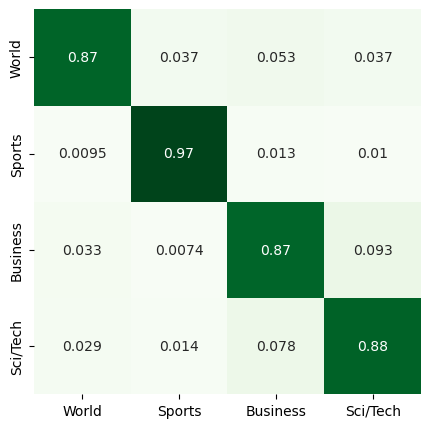

In [ ]:
y_pred = []; y_true = []                                          # lists to store predicted and real classes

for inputs, classes in test_loader:                              # iterate over test data
        inputs = inputs.to(device=device, dtype=torch.int32)     # We make sure the dtype in the Xs are of type tensor.float32
        classes = classes.to(device=device, dtype=torch.long)    # We make sure the dtype in the ys are of type tensor.long
        lengths = []                                            # Empty list to fill with the lengths of the xs
        for temp in inputs:                                          # Iterate through every element in x
            lengths.append(len(temp))                           # Append it to the list
        lengths = torch.tensor(lengths, dtype=torch.int32)      # convert to tensor with dtype int32
        output = lstm_model(inputs,lengths)                               # We feed Network with the batches

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()   # We obtain the predictions
        y_pred.extend(output)                                              # We Save the predictions in their list

        classes = classes.data.cpu().numpy()                     # We convert the real classes to numpy array
        y_true.extend(classes)                                   # We save them in their list

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)                     # We apply the function from sklearn
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in labels],   # We store it as a dataframe
                     columns = [i for i in labels])                                        # in %s and with indexes and columns
                                                                                           # with their classes
plt.figure(figsize = (5,5))                                     # Size of the plot
sn.heatmap(df_cm, annot=True,cbar=False,cmap="Greens")          # Heatmap to plot the confusion matrix

We see the stronger colors run through the diagonal meaning the model is quite good at classiying the news in the right category, even better than the normal RNN model

### Conclusions

As we practiced throughout the activity, we saw how a recurrent neural network uses the embeddings from past tokens to retain the context of the whole sentence, this is powerful since we not only are allowed to classify an independent input but a sequence of them. In the exploration work we run the code trying different architectures of RNNs and the one presented here was one of the most promising ones. It is important to emphasize that at the beginning the network performance was about 40% accuracy after 50 epochs, then we changed many hyperparameters and reconfigured the network. At one moment, we saw a lot of variation through the training epochs in the validation accuracy, so we found that our batch size wasn't ideal. We found out that the lower the batch size is, the longer it takes to train the network. However, we were able to obtain an accuracy value of 90% when using a batch size of 32. We also noticed that the learning rate had a big impact on the training of the model. When working with a simple RNN network, with only the embedding, RNN, and linear layers, we found that values between 1e-4 and 4e-4 were good values, at 4e-4 the network began to see the effects of overfitting, so we stayed at a learning rate of 2e-4 and limited epochs. We ended with an accuracy of about 88% with test data which was wonderful for us since the model was prevented from overfitting, and we can be certain that the network will perform relatively well with new examples. However, when changing our model to the one above, the best learning rate we got was for 1e-4. It was able to obtain 90% of accuracy in only 10 epochs.
In this scenario the difference in performance between our RNN model and our LSTM model was not very big, however it is important to emphasize that the best results were given by the LSTM model.] Furthermore, we defined several functions to explore the performance of the network, and we can see two examples almost at the end where the network performed well. In the end, the confusion matrix also helps us see the overall good performance of the network.

### References



Raschka, S., Liu, Y., Mirjalili, V., Dzhulgakov, D. (2022). Machine Learning with PyTorch and Scikit-Learn: Develop Machine Learning and Deep Learning Models with Python. United Kingdom: Packt Publishing.

Pepe Cantoral, Ph-D. (2023, October 23). Modelos secuenciales y REDES NEURONALES RECURRENTES YouTube.

Pepe Cantoral, Ph-D. (2023, October 26). ¿Qué son Word EMBEDDINGS? ¡Explorando Embeddings con GloVe y Python!

Pepe Cantoral, Ph-D. (2023, October 30). ¡LSTM: Todo lo que necesitas saber!